In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import sys
import re
import warnings
import itertools
warnings.simplefilter(action='ignore', category=FutureWarning)
from tensorflow.keras import Input, Model
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv1D
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import SGD, Adam
from sklearn.metrics import mean_absolute_error, explained_variance_score, mean_squared_error, make_scorer
from sklearn.linear_model import RidgeCV
warnings.resetwarnings()

Create a neural network model which can accurately predict the future new cases of COVID 19.

harder : make all windows vary in lengths between different batches. 
https://datascience.stackexchange.com/questions/26366/training-an-rnn-with-examples-of-different-lengths-in-keras

Now the key difficulty I think is how the data is to be rearranged. https://www.tensorflow.org/tutorials/structured_data/time_series indicates that I need a tensor with three dimensions,
axis = 0 is "batch size" axis = 1 is "time steps" and axis = 2 is "features".

Some things to keep in mind are that there may not be enough data for this to work well and
that there are many additions and changes that could be made, such as changing the architecture or adding LSTM layers.

In [2]:
def country_slice(data, locations):
    if type(locations)==str:
        return data[data.location==locations]
    else:
        return data[data.location.isin(locations)]
    
def time_slice(data, start, end, indexer='time_index'):
    if start < 0 and end < 0:
        if start == -1:
            start = data.loc[:, indexer].max()
        else:
            start = data.loc[:, indexer].max()+start
        if end == -1:
            end = data.loc[:, indexer].max()
        else:
            end = data.loc[:, indexer].max()+end
    return data[(data.loc[:, indexer] >= start) & (data.loc[:, indexer] <= end)]

def per_country_plot(data, feature, legend=True):
    data.set_index(['time_index', 'location']).loc[:, feature].unstack().plot(legend=legend)
    return None

def per_time_plot(data, feature, legend=True):
    data.set_index(['location','time_index']).loc[:, feature].unstack().plot(legend=legend)
    return None

def country_groupby(df):
    return [df[df.location==country].index for country in df.location.unique()]

def country_search(df, country):
    return df[df.location==country].index

def column_search(df, name, return_style='loc', threshold='contains'):
    if threshold=='contains':
        func = df.columns.str.contains
    else:
        func = df.columns.str.match
        
    if return_style == 'loc':
        return df.columns[func(name)]
    elif return_style== 'iloc':
        return np.where(func(name))[0]
    else:
        return None


def concatenate_4d_into_3d(splits, train_test_only=False):
    
    if train_test_only:
        (X_train, y_train, X_test, y_test) = splits
        X_train = np.concatenate(X_train, axis=0)
        y_train = np.concatenate(y_train, axis=0)
        X_test = np.concatenate(X_test, axis=0)
        y_test = np.concatenate(y_test, axis=0)
        concat_splits = (X_train, y_train, X_test, y_test) 
    else:
        (X_train, y_train, X_validate, y_validate, X_test, y_test) = splits
        X_train = np.concatenate(X_train, axis=0)
        y_train = np.concatenate(y_train, axis=0)
        X_validate = np.concatenate(X_validate, axis=0)
        y_validate = np.concatenate(y_validate, axis=0)
        X_test = np.concatenate(X_test, axis=0)
        y_test = np.concatenate(y_test, axis=0)
        concat_splits = (X_train, y_train, X_validate, y_validate, X_test, y_test) 
    return concat_splits

def transpose_for_separable2d(splits, train_test_only=False):
    if train_test_only:
        (X_train, y_train, X_test, y_test) = splits
        X_train = np.transpose(X_train, axes=[0,2,1,3])
        X_test = np.transpose(X_test, axes=[0,2,1,3])
        transpose_split = (X_train, y_train, X_test, y_test) 
    else:
        (X_train, y_train, X_validate, y_validate, X_test, y_test) = splits
        X_train = np.transpose(X_train, axes=[0,2,1,3])
        X_validate = np.transpose(X_validate, axes=[0,2,1,3])
        X_test = np.transpose(X_test, axes=[0,2,1,3])
        transpose_split = (X_train, y_train, X_validate, y_validate, X_test, y_test) 
    return transpose_split

    
def true_predict_plot(y_true, y_naive, y_predict, title='', suptitle='', scale=None,s=None):
    fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(20,5))
    if scale == 'log':
        ymax = np.max([np.log(1+y_true).max(), np.log(1+y_predict).max()])
        ax1.scatter(np.log(y_true+1), np.log(y_naive+1), s=s,alpha=0.7)
        ax1.plot([0, ymax], [0, ymax],color='r')
        ax2.scatter(np.log(y_true+1), np.log(y_predict+1), s=s,alpha=0.7)
        ax2.plot([0, ymax], [0, ymax],color='r')
    else:
        ymax = np.max([y_true.max(), y_predict.max()])
        ax1.scatter(y_true, y_naive, s=s)
        ax1.plot([0, ymax], [0, ymax],color='r')
        ax2.scatter(y_true, y_predict, s=s)
        ax2.plot([0, ymax], [0, ymax],color='r')
    ax1.set_xlabel('True value')
    ax1.set_ylabel('Predicted value')
    ax1.set_title('Naive model')

    ax2.set_xlabel('True value')
    ax2.set_ylabel('Predicted value')
    ax2.set_title(title)
    ax1.grid(True)
    ax2.grid(True)
    plt.suptitle(suptitle)
    plt.show()
    return None

def residual_plot(y_test, y_predict, title='', ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    ax.scatter(y_test, y_test-y_predict.ravel(), s=5)
    ax.set_ylabel('Residual')
    ax.set_xlabel('True value')
    ax.grid(True)
    return None

def residual_diff_plots(y_true, y_naive, y_predict,n_days_into_future, n_countries, scale=None):
    fig, axes = plt.subplots(2, 2, figsize=(20,5), sharey=True)
    (ax1,ax2,ax3,ax4) = axes.flatten()
    xrange = range(len(y_true))
    if scale=='log':
        ax1.plot(xrange, np.log(y_true+1)
             -np.log(y_naive+1))
        ax2.plot(xrange, np.log(y_true+1)
                 -np.log(y_predict+1))
        residual_plot(np.log(y_true+1),np.log(y_naive+1), ax=ax3)
        residual_plot(np.log(y_true+1),np.log(y_predict+1), ax=ax4)
    else:
        ax1.plot(xrange, y_true-y_naive)
        ax2.plot(xrange, y_true-y_predict)
        residual_plot(y_true,y_naive, ax=ax3)
        residual_plot(y_true,y_predict, ax=ax4)
    fig.suptitle('{}-day-into-future predictions'.format(n_days_into_future))
    ax1.set_title('Country-wise differences')
    ax2.set_title('Country-wise differences')
    ax1.set_ylabel('True - Naive')
    ax2.set_ylabel('True - CNN')
    ax1.grid(True)
    ax2.grid(True)
    plt.show()
    return None



def create_Xy(model_data, target_data, time_index, start_date, frame_size, n_days_into_future, n_countries):
    for max_date_in_window in range(start_date, time_index.max() - n_days_into_future + 2):
        # Take all model_data with date proxy less than numerical value, leading_window_date_not_included
        frame_data = model_data[(time_index <= max_date_in_window-1) & 
                                (time_index >= max_date_in_window-frame_size)]
        #     print(frame_data.shape)
        # Reshape the array such that each element along axis=0 is a time series of all feature model_data of a specific country.
        reshaped_frame_data = frame_data.values.reshape(n_countries, frame_size, -1)
#         print(reshaped_frame_data.shape)
        #     print(reshaped_frame_data.shape)
        # Truncate / pad the windows along the "time" axis, axis=1. (pad_sequences takes in an iterable of iterables;
        # the first axis is always the default iteration axis. 
        # *********************** WARNING: pad_sequences converts to integers by default *********************
        resized_frame_data = pad_sequences(reshaped_frame_data, maxlen=frame_size, dtype=np.float64)
        frame_data_4D = resized_frame_data[np.newaxis, :, :, :]
        if max_date_in_window == start_date:
            print('Starting with frame ranging time_index values:', max_date_in_window-frame_size, max_date_in_window - 1)
            X = frame_data_4D.copy()
        else:
            X = np.concatenate((X, frame_data_4D),axis=0)
    print('Ending with frame ranging time_index values:', max_date_in_window-frame_size, max_date_in_window - 1)
    y = target_data.values.reshape(-1, time_index.nunique()).transpose()[-X.shape[0]:,:]
    return X, y

def split_Xy(X, y, frame_size, n_validation_frames, n_test_frames, train_test_only=False, model_type='cnn'):
    """ Split into training, validation and test data.
    """
    
    # the indices for the train-validate-test splits for when the predictors are put in a 2-d format.
    train_indices = list(range(n_countries*0, n_countries*(len(X)-(n_validation_frames+n_test_frames))))
    validate_indices = list(range(n_countries*(len(X)-(n_validation_frames+n_test_frames)), n_countries*(len(X)-n_test_frames)))
    test_indices = list(range(n_countries*(len(X)-n_test_frames), n_countries*len(X)))
    indices = (train_indices, validate_indices, test_indices)

    # Note that the last frame (date_range) that exists in X has already been determined by the choice of the number
    # of steps to predict in the future, this is only slicing the frames. 
    if train_test_only:
        X_train= X[:-n_test_frames,:,:,:]
        y_train =  y[:-n_test_frames,:]
        X_test = X[-n_test_frames:, :, :, :] 
        y_test = y[-n_test_frames:, :]
        splits =  (X_train, y_train, X_test, y_test)
    else:
        y_train =  y[:-(n_validation_frames+n_test_frames),:]
        y_validate = y[-(n_validation_frames+n_test_frames):-n_test_frames, :]
        X_train= X[:-(n_validation_frames+n_test_frames),:,:,:]
        y_train =  y[:-(n_validation_frames+n_test_frames),:]
        X_validate = X[-(n_validation_frames+n_test_frames):-n_test_frames, :, :, :]
        y_validate = y[-(n_validation_frames+n_test_frames):-n_test_frames, :]
        X_test = X[-n_test_frames:, :, :, :] 
        y_test = y[-n_test_frames:, :]
        splits =  (X_train, y_train, X_validate, y_validate,
                   X_test, y_test)

    return splits, indices


def flatten_Xy(splits):
    (X_train, y_train, X_validate, y_validate, X_test, y_test) = splits
    X_train_flat =np.concatenate(X_train.reshape(X_train.shape[0], X_train.shape[1], -1), axis=0)
    X_validate_flat =np.concatenate(X_validate.reshape(X_validate.shape[0], X_validate.shape[1], -1), axis=0)
    X_test_flat =np.concatenate(X_test.reshape(X_test.shape[0], X_test.shape[1], -1), axis=0)
    y_train_flat = y_train.ravel()
    y_validate_flat = y_validate.ravel()
    y_test_flat = y_test.ravel()
    flat_splits = (X_train_flat , y_train_flat , X_validate_flat , y_validate_flat , X_test_flat , y_test_flat )
    return flat_splits

def model_analysis(y_true, y_naive, y_predict,n_countries, title='',suptitle=''):
    print('There were {} negative predictions'.format(len(y_predict[y_predict<0])))
    #     y_predict[y_predict<0]=0
    mse_train_naive = mean_squared_error(y_true.ravel(), y_naive.ravel())
    mse_predict = mean_squared_error(y_true.ravel(), y_predict)
    r2_train_naive = explained_variance_score(y_true.ravel(), y_naive.ravel())
    r2_predict = explained_variance_score(y_true.ravel(), y_predict)

    print('{}-step MSE [Naive, {}] = [{},{}]'.format(
    n_days_into_future,title, mse_train_naive, mse_predict))
    print('{}-step R^2 [Naive, {}] = [{},{}]'.format(
    n_days_into_future,title, r2_train_naive, r2_predict))

    true_predict_plot(y_true.ravel(), y_naive.ravel(), y_predict, title=title, suptitle=suptitle)
    residual_diff_plots(y_true.ravel(), y_naive.ravel(), y_predict , n_days_into_future, n_countries)
    return None


def normalize_Xy(splits, feature_range=(0., 1.0), normalization_method='minmax',
                        train_test_only=False, feature_indices=None):
    """ Split into training, validation and test data.
    Normalize with respect to some absolute max, just choose 2*absolute max of training set. 

    """
    
    min_, max_ = feature_range
    (X_train, y_train, X_validate, y_validate, X_test, y_test) = splits
    feature_minima = X_train[:,:,:,:].min((0,1,2))[np.newaxis,np.newaxis,np.newaxis,:]
    feature_maxima = 2*X_train[:,:,:,:].max((0,1,2))[np.newaxis,np.newaxis,np.newaxis,:]
    feature_denominator = feature_maxima-feature_minima
    # get the shape of each split's array, so that array arithmetic can be done. 
    train_tile_shape = np.array(np.array(X_train.shape)/np.array(feature_maxima.shape),int)
    validate_tile_shape = np.array(np.array(X_validate.shape)/np.array(feature_maxima.shape),int)
    test_tile_shape = np.array(np.array(X_test.shape)/np.array(feature_maxima.shape),int)

    # using X - X_min / (X_max-X_min). Form denominator
    train_denominator = np.tile(feature_denominator, train_tile_shape)
    validate_denominator = np.tile(feature_denominator, validate_tile_shape)
    test_denominator = np.tile(feature_denominator, test_tile_shape)
    
    # and then the minima.
    train_minima = np.tile(feature_minima,train_tile_shape)
    validate_minima = np.tile(feature_minima,validate_tile_shape)
    test_minima = np.tile(feature_minima,test_tile_shape)
    
    # factor of 1/max_ accounts for absolute maximum that is outside of the data (i.e. potential future values). 
    X_train_scaled = (max_-min_)*(X_train - train_minima)/train_denominator
    X_validate_scaled = (max_-min_)*(X_validate - validate_minima)/validate_denominator
    X_test_scaled = (max_-min_)*(X_test - test_minima)/test_denominator

    
    scaled_splits = (X_train_scaled, y_train, X_validate_scaled, y_validate, X_test_scaled, y_test) 
    scaling_arrays =  (feature_maxima, feature_minima, feature_denominator)

    return scaled_splits, scaling_arrays

In [3]:
# Import cleaned data produced by other notebook. 
data = pd.read_csv('cnn_data.csv',index_col=0)
data = data.drop(columns=['date'])

In [4]:
n_countries = data.location.nunique()
n_dates = data.time_index.nunique()
n_countries, n_dates

(132, 161)

In [5]:
# data = data[data.time_index>=40]
model_data = data.copy().iloc[:, 3:]
new_cases_index = column_search(model_data,'new_cases_per_million', threshold='match', return_style='iloc')[0]
n_countries = data.location.nunique()
target_data = data.new_cases_per_million
time_index = data.time_index

frame_size = 28
start_date = frame_size

n_validation_frames = 7
n_test_frames = 1
n_days_into_future = 1

In [6]:
X, y = create_Xy(model_data, target_data, time_index, start_date, frame_size, n_days_into_future, n_countries)
splits, indices = split_Xy(X, y, frame_size, n_validation_frames, n_test_frames)

scaled_splits, scaling_arrays =  normalize_Xy(splits, feature_range=(0,1.0), 
                                                                  normalization_method='minmax',
                                                                  train_test_only=False,
                                                                  feature_indices=None)
# if need to supply folds for sklearn CV regression functions.
(X_nn_train, y_nn_train, X_nn_validate, y_nn_validate, X_nn_test, y_nn_test) = scaled_splits
(train_indices, validate_indices, test_indices) = indices

Starting with frame ranging time_index values: 0 27
Ending with frame ranging time_index values: 132 159


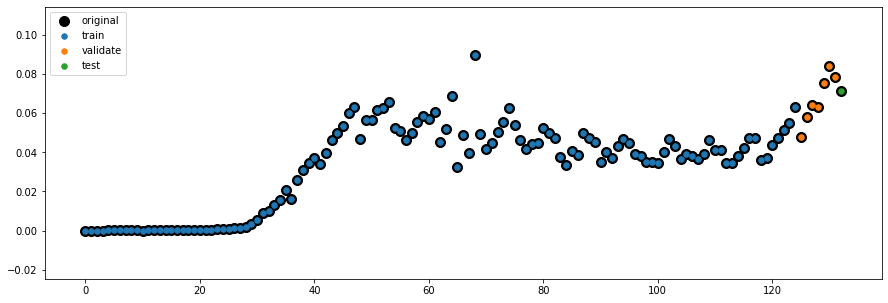

In [7]:
X_scaled_tmp = np.concatenate((X_nn_train,X_nn_validate,X_nn_test), axis=0)

fig, ax = plt.subplots(1,1, figsize=(15,5))
ax.scatter(range(len(X_scaled_tmp)), X_scaled_tmp[:,np.where(data.location.unique()=='United States')[0],-1,new_cases_index], s=100,color='k', label='original')
ax.scatter(range(len(scaled_splits[0])), scaled_splits[0][:,np.where(data.location.unique()=='United States')[0],-1,new_cases_index], s=30, label='train')
ax.scatter(range(len(scaled_splits[0]), len(scaled_splits[0])+len(scaled_splits[2])), scaled_splits[2][:,np.where(data.location.unique()=='United States')[0],-1,new_cases_index], s=30, label='validate')
ax.scatter(range(len(scaled_splits[0])+len(scaled_splits[2]), len(X)), X_nn_test[:,np.where(data.location.unique()=='United States')[0],-1,new_cases_index], s=30, label='test')
plt.legend()
_ = plt.show()

In [8]:
flat_splits = flatten_Xy(scaled_splits)
(X_nn_train_model,y_nn_train_model,X_nn_validate_model,
 y_nn_validate_model,X_nn_test_model,y_nn_test_model) = flat_splits
X_for_naive_slicing = np.concatenate(X.reshape(X.shape[0], X.shape[1], -1), axis=0)
n_features = X.shape[-1]
last_day_new_cases_index = np.ravel_multi_index([[frame_size-1],[new_cases_index]],(frame_size, n_features))
y_train_naive = X_for_naive_slicing[train_indices, last_day_new_cases_index].ravel()
y_validate_naive =  X_for_naive_slicing[validate_indices, last_day_new_cases_index].ravel()
y_test_naive =  X_for_naive_slicing[test_indices, last_day_new_cases_index].ravel()

In [9]:
epochs_list = [50, 100, 200]
batch_size_list = [64, 256, 1024]
fc_quotient_list = [1,2,4,8,16]
parameter_combinations = list(itertools.product(epochs_list, batch_size_list, fc_quotient_list))

In [10]:
if os.path.isfile('nn_score_logging.csv'):
    score_logging_df = pd.read_csv('nn_score_logging.csv', index_col=0)
else:
    score_logging_df = pd.DataFrame(np.array(parameter_combinations), 
                                    columns=['epochs','batch_size','fc_quotient'])
    score_logging_df.loc[:, 'mean_squared_error'] = np.nan
    score_logging_df.loc[:, 'mean_absolute_error'] = np.nan
    score_logging_df.loc[:, 'explained_variance'] = np.nan
    score_logging_df.loc[:, 'naive_mean_absolute_error'] = np.nan
    score_logging_df.loc[:, 'naive_explained_variance'] = np.nan
    score_logging_df.loc[:, 'naive_mean_squared_error'] = np.nan

In [11]:
kernel0 = RandomNormal(seed=0)
kernel1 = RandomNormal(seed=1)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [12]:
for i, hyper_parameters in enumerate(parameter_combinations):
    
    (epochs, batch_size, fc_quotient) = hyper_parameters
    
    if score_logging_df.isna().loc[i,'mean_squared_error']:
        nn_input = Input(shape=(np.prod(X_nn_train.shape[2:]),))
        flat = Flatten()(nn_input)
        dense0 = Dense(int(frame_size//fc_quotient), 
                        use_bias=False,
                       kernel_initializer=kernel0,
                       )(flat)
        dense1 = Dense(1, 
                        activation='relu',
                        use_bias=False,
                       kernel_initializer=kernel1,
                       )(dense0)

        nn = Model(inputs=nn_input, outputs=dense1)
        nn.compile(loss='mse', optimizer=Adam())
        history = nn.fit(X_nn_train_model, y_nn_train_model, epochs=epochs, validation_data=(X_nn_validate_model, y_nn_validate_model), 
                  batch_size=batch_size, verbose=0)
        
        y_true = y_nn_validate_model.ravel()
        y_predict = nn.predict(X_nn_validate_model).ravel()
        y_naive = y_validate_naive.ravel()

        score_logging_df.loc[i,'naive_mean_squared_error'] = mean_squared_error(y_true.ravel(), y_naive.ravel())
        score_logging_df.loc[i,'mean_squared_error']  = mean_squared_error(y_true.ravel(), y_predict)
        score_logging_df.loc[i,'naive_explained_variance']  = explained_variance_score(y_true.ravel(), y_naive.ravel())
        score_logging_df.loc[i,'explained_variance']  = explained_variance_score(y_true.ravel(), y_predict)
        score_logging_df.loc[i,'naive_mean_absolute_error']  = mean_absolute_error(y_true.ravel(), y_naive.ravel())
        score_logging_df.loc[i,'mean_absolute_error']  = mean_absolute_error(y_true.ravel(), y_predict)
        # every time a new score is calculated, overwrite the original file, to save space but also save progress scoring.
        score_logging_df.to_csv('nn_score_logging.csv')
    else:
        pass
    
    print('#',end='')
    if (i % 50 == 0) & i>0:
          print('{} runs completed'.format(str(i)))

#############################################

In [13]:
score_logging_df.loc[score_logging_df.mean_squared_error.idxmin(),:]

epochs                       100.000000
batch_size                    64.000000
fc_quotient                    2.000000
mean_squared_error           301.914860
mean_absolute_error            9.157797
explained_variance             0.912352
naive_mean_absolute_error      6.381940
naive_explained_variance       0.915816
naive_mean_squared_error     283.717052
Name: 16, dtype: float64

In [14]:
best_model_parameters = score_logging_df.loc[score_logging_df.mean_squared_error.idxmin(),:].iloc[:3]
print(best_model_parameters)

epochs         100.0
batch_size      64.0
fc_quotient      2.0
Name: 16, dtype: float64


In [15]:
(epochs, batch_size, fc_quotient) = best_model_parameters
    
nn_input = Input(shape=(np.prod(X_nn_train.shape[2:]),))
flat = Flatten()(nn_input)
dense0 = Dense(int(frame_size//fc_quotient), 
                use_bias=False,
               kernel_initializer=kernel0,
               )(flat)
dense1 = Dense(1, 
                activation='relu',
                use_bias=False,
               kernel_initializer=kernel1,
               )(dense0)


best_nn = Model(inputs=nn_input, outputs=dense1)
best_nn.compile(loss='mse', optimizer=Adam())
history = best_nn.fit(X_nn_train_model, y_nn_train_model, epochs=int(epochs),
                      validation_data=(X_nn_validate_model, y_nn_validate_model), 
          batch_size=int(batch_size), verbose=0)

In [16]:
best_nn.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 812)]             0         
_________________________________________________________________
flatten (Flatten)            (None, 812)               0         
_________________________________________________________________
dense (Dense)                (None, 14)                11368     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 14        
Total params: 11,382
Trainable params: 11,382
Non-trainable params: 0
_________________________________________________________________


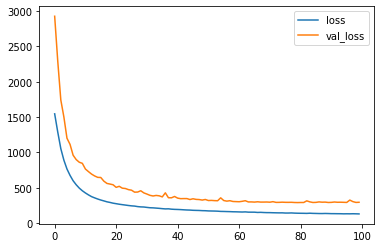

In [17]:
_ = plt.plot(history.history['loss'], label='loss')
_ = plt.plot(history.history['val_loss'], label='val_loss')
_ = plt.legend()
_ = plt.show()

Predictions made on the training set (for determining whether or not we overtraining 

There were 0 negative predictions
1-step MSE [Naive, NN model] = [138.32170971539392,128.33542295874997]
1-step R^2 [Naive, NN model] = [0.9171090031653221,0.9238999339001969]


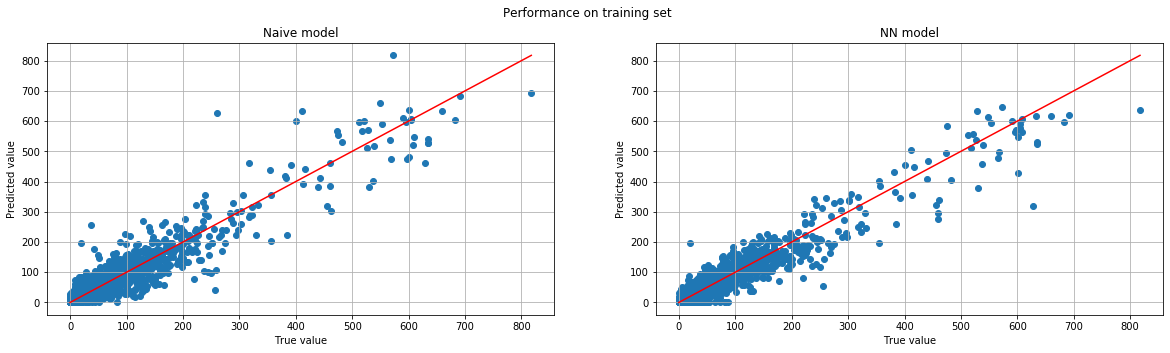

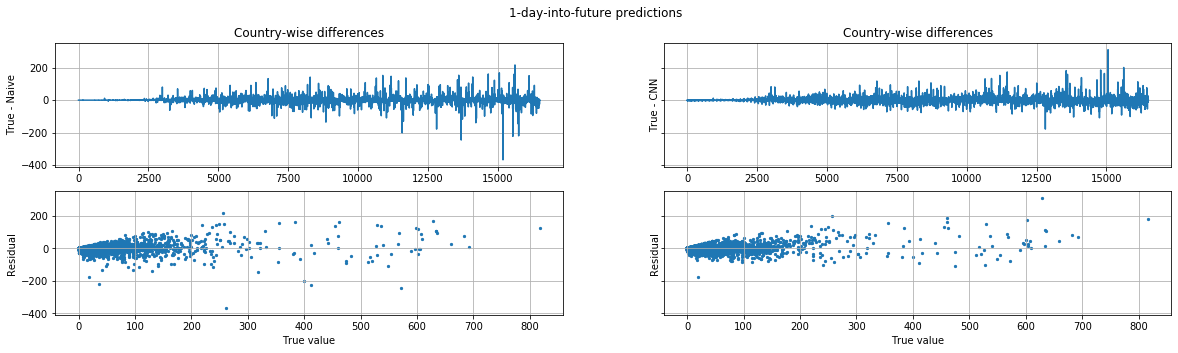

In [18]:
y_true = y_nn_train_model.ravel()
y_predict = best_nn.predict(X_nn_train_model).ravel()
model_analysis(y_true, y_train_naive, y_predict, n_countries, title='NN model', suptitle='Performance on training set')

Predictions made on the validation set.

There were 0 negative predictions
1-step MSE [Naive, NN model] = [283.71705200108227,296.1208879900593]
1-step R^2 [Naive, NN model] = [0.9158164771020348,0.9134916835988759]


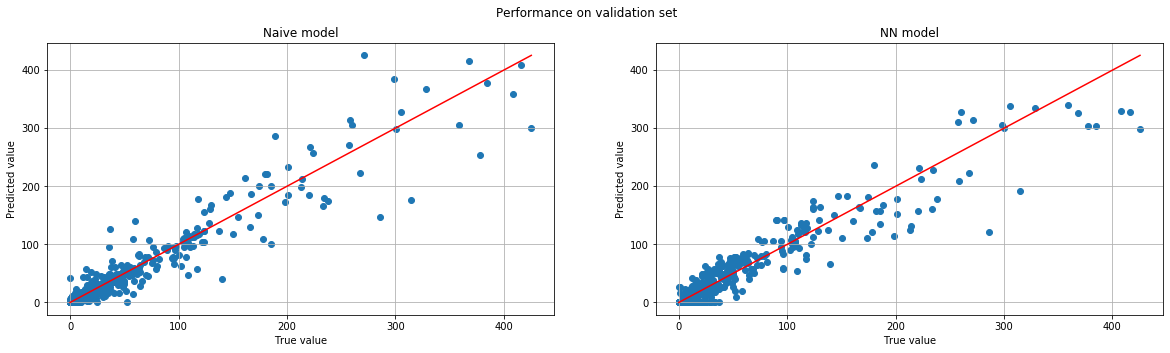

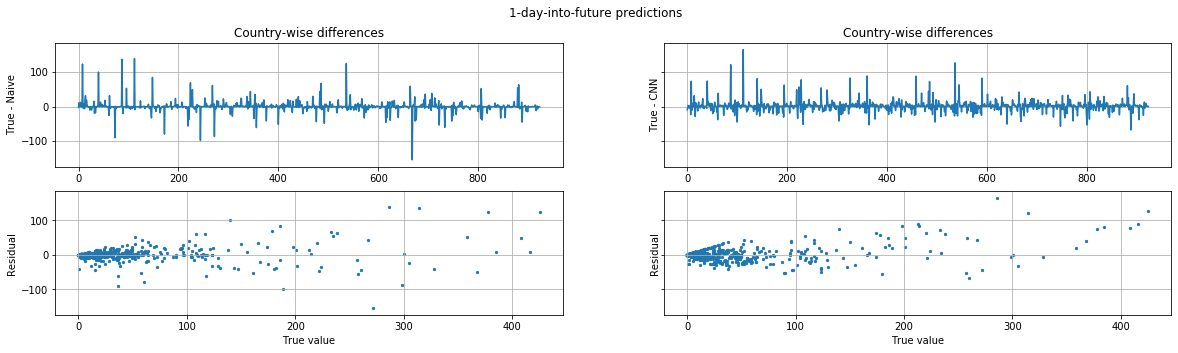

In [19]:
y_true = y_nn_validate_model.ravel()
y_predict = best_nn.predict(X_nn_validate_model).ravel()
model_analysis(y_true, y_validate_naive, y_predict, n_countries, title='NN model', suptitle='Performance on validation set')

Predictions made on the hold-out set (final evaluation).

There were 0 negative predictions
1-step MSE [Naive, NN model] = [258.31770921212126,346.00282784977907]
1-step R^2 [Naive, NN model] = [0.9074361696088415,0.8764574322888673]


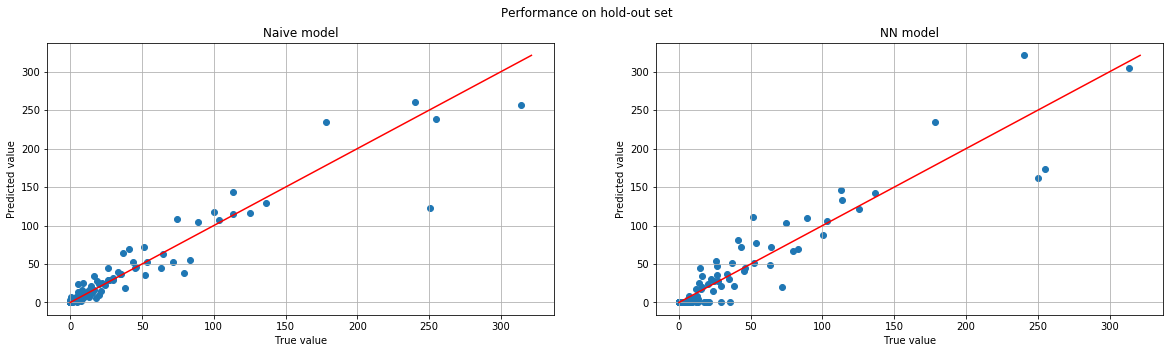

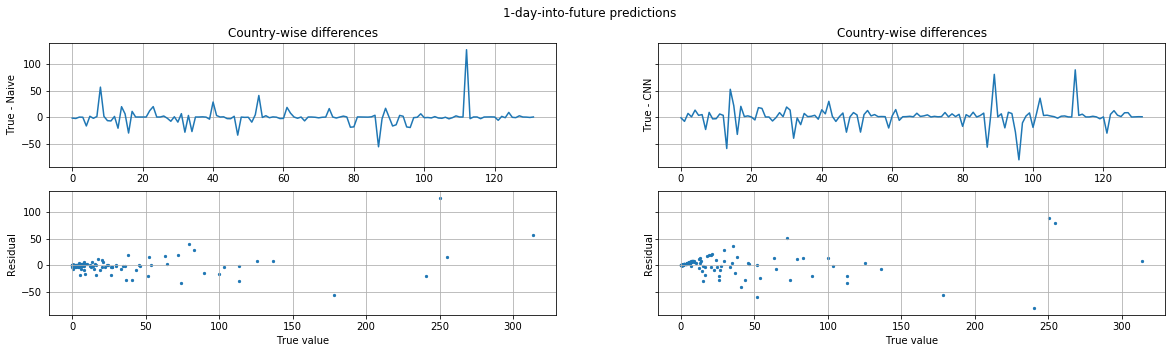

In [20]:
y_true = y_nn_test_model.ravel()
y_predict = best_nn.predict(X_nn_test_model).ravel()
model_analysis(y_true, y_test_naive, y_predict, n_countries, title='NN model', suptitle='Performance on hold-out set')

At this stage, it seems that the neural network model in its current form is unable of producing accurate predictions that beat a simple naive baseline model. In fact, the average performance is much worse than the naive baseline, as indicated by the scoring distribution

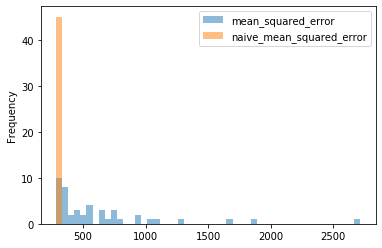

In [21]:
score_logging_df.loc[:,column_search(score_logging_df,'squared')].plot.hist(alpha=0.5, bins=50)